In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker

from scipy.stats import shapiro

In [2]:
df = pd.read_csv('Speed Dating Data.csv',
                 encoding="cp1252")
df.tail()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
8373,552,22.0,1,44,2,21,22,14,10.0,5,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8374,552,22.0,1,44,2,21,22,13,10.0,4,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8375,552,22.0,1,44,2,21,22,19,10.0,10,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8376,552,22.0,1,44,2,21,22,3,10.0,16,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8377,552,NaN,1,44,2,21,22,2,10.0,15,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0


In [3]:
df = df[['id', 'partner', 'gender', 'wave',
         'dec_o', 'pf_o_att', 'attr_o', 'match',
         'attr1_1', 'attr3_1']]
df.tail()

,id,partner,gender,wave,dec_o,pf_o_att,attr_o,match,attr1_1,attr3_1
8373,22.0,18,1,21,1,10.0,10.0,0,70.0,8.0
8374,22.0,19,1,21,0,50.0,6.0,0,70.0,8.0
8375,22.0,20,1,21,0,40.0,2.0,0,70.0,8.0
8376,22.0,21,1,21,1,10.0,5.0,0,70.0,8.0
8377,NaN,22,1,21,1,20.0,8.0,0,70.0,8.0


In [4]:
df[['attr_o']].isnull().groupby(df['wave']).sum()

,attr_o
wave,
1,1
2,7
3,12
4,1
5,15
6,0
7,2
8,5
9,1


In [5]:
filtered = df.query('wave in [6, 10, 17, 18, 20]')
filtered.describe()

,id,partner,gender,wave,dec_o,pf_o_att,attr_o,match,attr1_1,attr3_1
count,648.000000,648.000000,648.000000,648.000000,648.000000,643.000000,648.000000,648.000000,643.000000,643.000000
mean,5.288580,5.288580,0.500000,14.901235,0.450617,24.106221,6.120370,0.160494,24.106221,7.046656
std,3.195107,3.195107,0.500386,4.299757,0.497940,13.152015,1.896923,0.367347,13.152015,1.464321
min,1.000000,1.000000,0.000000,6.000000,0.000000,6.670000,0.000000,0.000000,6.670000,2.000000
25%,3.000000,3.000000,0.000000,10.000000,0.000000,15.000000,5.000000,0.000000,15.000000,7.000000
50%,5.000000,5.000000,0.500000,17.000000,0.000000,20.000000,6.000000,0.000000,20.000000,7.000000
75%,7.000000,7.000000,1.000000,17.000000,1.000000,30.000000,7.000000,0.000000,30.000000,8.000000
max,14.000000,14.000000,1.000000,20.000000,1.000000,90.000000,10.000000,1.000000,90.000000,10.000000


In [6]:
filtered.groupby(['wave'])['id'].nunique()

wave
6      7
10     9
17    14
18     6
20     8
Name: id, dtype: int64

In [7]:
filtered = filtered[filtered['wave'] == 17]

In [8]:
seed_value = 34 # You can set any seed value you like

Faker.seed(seed_value)
fake = Faker()

# Assuming 'filtered' is your DataFrame

# Function to generate a name based on gender
def generate_name(gender):
    if gender == 1: # Assuming 1 is male
        return fake.first_name_male()
    else: # Assuming 0 is female
        return fake.first_name_female()

# Create the new_id for unique combinations of wave, id and gender
unique_people_id = filtered[['wave', 'id', 'gender']].drop_duplicates().sort_values(
    by=['wave', 'gender']
)
unique_people_id['new_id'] = unique_people_id['gender'].apply(generate_name)

# Merge the new_id into the original dataframe
filtered = filtered.merge(unique_people_id, on=['wave', 'id', 'gender'], how='left')

# Create a dictionary to map from (wave, id, gender) to new_id (which now contains names)
id_dict = unique_people_id.set_index(['wave', 'id', 'gender'])['new_id'].to_dict()

# Then create the new_partner_id by mapping the (wave, partner, gender) to new_id
filtered['new_partner_id'] = filtered.apply(
    lambda row: id_dict.get((row['wave'], row['partner'], abs(row['gender']-1))),
    axis=1
)

In [9]:
filtered[filtered['wave']==17][:60]

,id,partner,gender,wave,dec_o,pf_o_att,attr_o,match,attr1_1,attr3_1,new_id,new_partner_id
0,1.0,1,0,17,0,35.0,5.0,0,10.0,5.0,Kendra,Jorge
1,1.0,2,0,17,1,35.0,7.0,0,10.0,5.0,Kendra,Christopher
2,1.0,3,0,17,1,40.0,5.0,0,10.0,5.0,Kendra,Donald
3,1.0,4,0,17,1,30.0,6.0,0,10.0,5.0,Kendra,Leroy
4,1.0,5,0,17,0,50.0,3.0,0,10.0,5.0,Kendra,Ricardo
5,1.0,6,0,17,0,40.0,6.0,0,10.0,5.0,Kendra,Paul
6,1.0,7,0,17,1,30.0,7.0,0,10.0,5.0,Kendra,Brandon
7,1.0,8,0,17,0,15.0,5.0,0,10.0,5.0,Kendra,Antonio
8,1.0,9,0,17,1,25.0,8.0,0,10.0,5.0,Kendra,David
9,1.0,10,0,17,1,55.0,10.0,0,10.0,5.0,Kendra,Juan


In [10]:
filtered[filtered['wave']==17][-60:]

,id,partner,gender,wave,dec_o,pf_o_att,attr_o,match,attr1_1,attr3_1,new_id,new_partner_id
220,9.0,1,1,17,0,10.0,6.0,0,25.0,8.0,David,Kendra
221,9.0,2,1,17,1,15.0,9.0,1,25.0,8.0,David,Laurie
222,9.0,3,1,17,1,15.0,8.0,0,25.0,8.0,David,Sarah
223,9.0,4,1,17,0,20.0,6.0,0,25.0,8.0,David,Stephanie
224,9.0,5,1,17,0,30.0,7.0,0,25.0,8.0,David,Sonia
225,9.0,6,1,17,1,25.0,9.0,1,25.0,8.0,David,Holly
226,9.0,7,1,17,1,28.0,10.0,1,25.0,8.0,David,Tiffany
227,9.0,8,1,17,1,15.0,7.0,1,25.0,8.0,David,Jessica
228,9.0,9,1,17,0,14.0,8.0,0,25.0,8.0,David,Elizabeth
229,9.0,10,1,17,1,20.0,9.0,1,25.0,8.0,David,Anna


In [11]:
filtered.isnull().sum()

id                0
partner           0
gender            0
wave              0
dec_o             0
pf_o_att          0
attr_o            0
match             0
attr1_1           0
attr3_1           0
new_id            0
new_partner_id    0
dtype: int64

# Speed Dating as Undirected Graphs

In [12]:
# Initialize a Graph
G = nx.Graph()

# Create nodes
for idx, row in filtered.iterrows():
    G.add_node(row['new_id'], gender=row['gender'])
    
# Filter rows where match equals 1
match_df = filtered[filtered['match']==1]

# Create edges
for idx, row in match_df.iterrows():
    G.add_edge(row['new_id'], row['new_partner_id'])

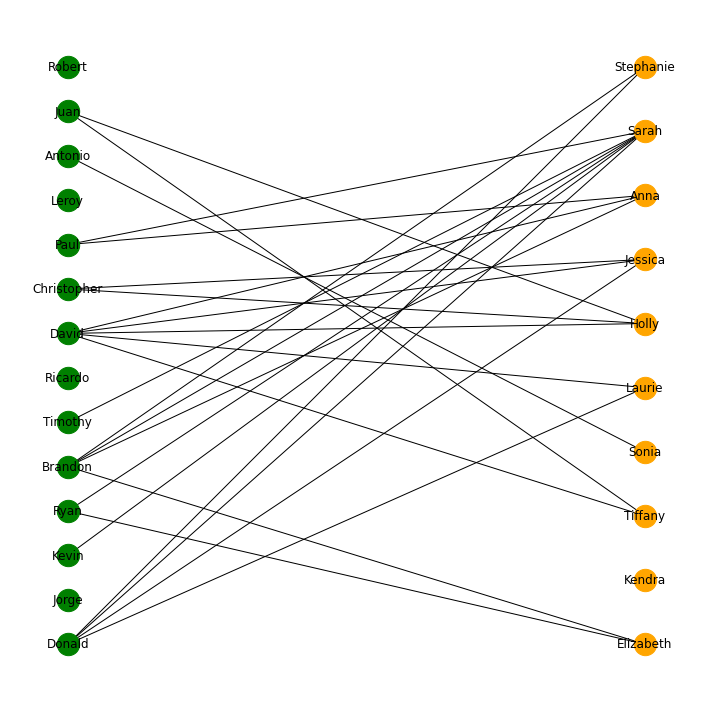

In [13]:
# Determine the nodes for each partition
top_nodes = [n for n, d in G.nodes(data=True) if d['gender']==1]  # assuming 1 is male
bottom_nodes = [n for n, d in G.nodes(data=True) if d['gender']==0]  # assuming 0 is female

# Create the bipartite layout
pos = nx.bipartite_layout(G, top_nodes)

# Draw the graph
plt.figure(figsize=(10,10))

# Nodes
nx.draw_networkx_nodes(G, pos, nodelist=top_nodes, node_color='green', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=bottom_nodes, node_color='orange', node_size=500)

# Edges
nx.draw_networkx_edges(G, pos, width=1)

# Labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.axis('off')
plt.tight_layout()
plt.savefig('undirected.png', dpi=100)
plt.show()

In [14]:
# Initialize lists to store data
nodes_list = []
degree_list = []
gender_list = []

# Loop over genders
for gender, color in zip([0, 1], ['female', 'male']):
    # Select nodes of this gender
    selected_nodes = [n for n, d in G.nodes(data=True) if d['gender']==gender]
    
    # Compute degrees
    degrees = [G.degree(n) for n in selected_nodes]
    avg_deg = sum(degrees) / len(degrees) if degrees else 0

    # Store results
    nodes_list.append(len(selected_nodes))
    degree_list.append(avg_deg)
    gender_list.append(color)

# Create DataFrame
df = pd.DataFrame({
    'gender': gender_list,
    'nodes': nodes_list,
    'avg_degree': degree_list
})

df

,gender,nodes,avg_degree
0,female,10,2.400000
1,male,14,1.714286


In [15]:
# Initialize lists to store data
male_degree_list = []
female_degree_list = []

# Select nodes for males and females
male_nodes = [n for n, d in G.nodes(data=True) if d['gender']==1]
female_nodes = [n for n, d in G.nodes(data=True) if d['gender']==0]

# Compute degrees and sort for males
male_degrees = sorted([(n, G.degree(n)) for n in male_nodes], key=lambda x: -x[1])

# Compute degrees and sort for females
female_degrees = sorted([(n, G.degree(n)) for n in female_nodes], key=lambda x: -x[1])

# Get the degree list for males and females
male_degree_list = [(n, d) for n, d in male_degrees]
female_degree_list = [(n, d) for n, d in female_degrees]

# Create DataFrame
df = pd.DataFrame({
    'male': pd.Series(male_degree_list),
    'female': pd.Series(female_degree_list)
})

df

,male,female
0,"(David, 5)","(Sarah, 6)"
1,"(Donald, 4)","(Holly, 3)"
2,"(Brandon, 4)","(Jessica, 3)"
3,"(Christopher, 2)","(Anna, 3)"
4,"(Paul, 2)","(Laurie, 2)"
5,"(Juan, 2)","(Stephanie, 2)"
6,"(Ryan, 2)","(Tiffany, 2)"
7,"(Antonio, 1)","(Elizabeth, 2)"
8,"(Timothy, 1)","(Sonia, 1)"
9,"(Kevin, 1)","(Kendra, 0)"


In [16]:
# Extract degree values from the tuples in the dataframe
male_degrees = [degree for node, degree in df['male'].dropna()]
female_degrees = [degree for node, degree in df['female'].dropna()]

# Compute min, max, avg for males
male_min_degree = np.min(male_degrees)
male_max_degree = np.max(male_degrees)
male_avg_degree = np.mean(male_degrees)

print("Male minimum degree: ", male_min_degree)
print("Male maximum degree: ", male_max_degree)
print("Male average degree: ", male_avg_degree)

print('-----')

# Compute min, max, avg for females
female_min_degree = np.min(female_degrees)
female_max_degree = np.max(female_degrees)
female_avg_degree = np.mean(female_degrees)

print("Female minimum degree: ", female_min_degree)
print("Female maximum degree: ", female_max_degree)
print("Female average degree: ", female_avg_degree)

Male minimum degree:  0
Male maximum degree:  5
Male average degree:  1.7142857142857142
-----
Female minimum degree:  0
Female maximum degree:  6
Female average degree:  2.4


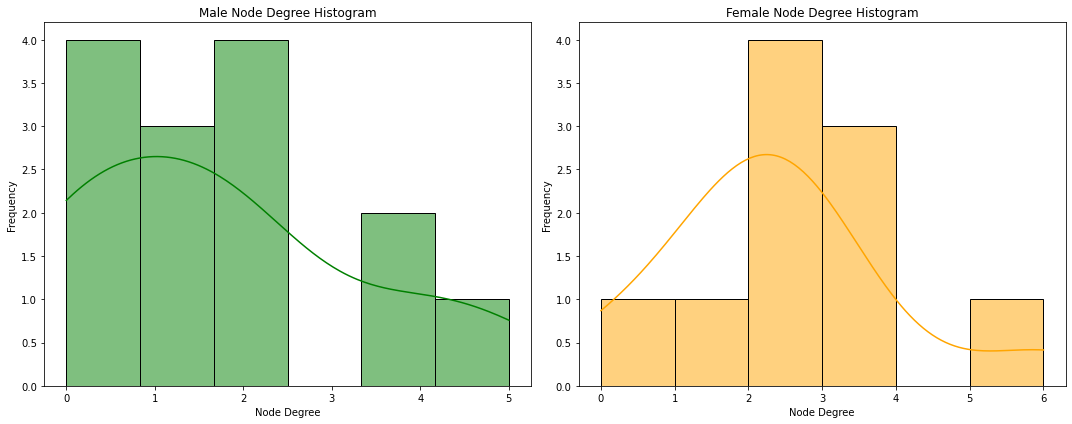

In [17]:
# Create two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot histogram for male degrees
sns.histplot(male_degrees, kde=True, color='green', bins=6, ax=ax[0])
ax[0].set_title('Male Node Degree Histogram')
ax[0].set_xlabel('Node Degree')
ax[0].set_ylabel('Frequency')

# Plot histogram for female degrees
sns.histplot(female_degrees, kde=True, color='orange', bins=6, ax=ax[1])
ax[1].set_title('Female Node Degree Histogram')
ax[1].set_xlabel('Node Degree')
ax[1].set_ylabel('Frequency')

# Adjust space between plots
plt.tight_layout()
plt.savefig('undir_hist.png', dpi=100)

# Show the plot
plt.show()


In [18]:
male_degrees_values = [degree for node, degree in df['male'].dropna()]
female_degrees_values = [degree for node, degree in df['female'].dropna()]

# perform the Shapiro-Wilk test
stat, p = shapiro(male_degrees_values)
print('Male Degrees: Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = shapiro(female_degrees_values)
print('Female Degrees: Statistics=%.3f, p=%.3f' % (stat, p))


Male Degrees: Statistics=0.873, p=0.047
Female Degrees: Statistics=0.879, p=0.127


In [19]:
# project the bipartite graph onto the male nodes
G_projected_male = nx.bipartite.projected_graph(G, male_nodes)

# compute the average clustering coefficient
avg_clustering_male = nx.average_clustering(G_projected_male)

# repeat for female nodes
G_projected_female = nx.bipartite.projected_graph(G, female_nodes)
avg_clustering_female = nx.average_clustering(G_projected_female)

print("Average Clustering Coefficient for Males:", avg_clustering_male)
print("Average Clustering Coefficient for Females:", avg_clustering_female)

Average Clustering Coefficient for Males: 0.5275510204081633
Average Clustering Coefficient for Females: 0.6685714285714285


In [20]:
from networkx import connected_components
print("Number of Connected Components:", len(list(connected_components(G))))

Number of Connected Components: 7


In [21]:
# Compute the centralities and sort them
degree_centralities = sorted(nx.degree_centrality(G).items(), key=lambda x: -x[1])
closeness_centralities = sorted(nx.closeness_centrality(G).items(), key=lambda x: -x[1])
betweenness_centralities = sorted(nx.betweenness_centrality(G).items(), key=lambda x: -x[1])

# Create dataframes for each centrality measure
df_degree = pd.DataFrame(degree_centralities, columns=['Id', 'Degree'])
df_closeness = pd.DataFrame(closeness_centralities, columns=['Id', 'Closeness'])
df_betweenness = pd.DataFrame(betweenness_centralities, columns=['Id', 'Betweenness'])

# Merge the dataframes on 'Id'
df_centrality = df_degree.merge(df_closeness, on='Id').merge(df_betweenness, on='Id')

# Convert columns to tuples
df_centrality['Degree'] = df_centrality.apply(lambda row: (row['Id'], row['Degree']), axis=1)
df_centrality['Closeness'] = df_centrality.apply(lambda row: (row['Id'], row['Closeness']), axis=1)
df_centrality['Betweenness'] = df_centrality.apply(lambda row: (row['Id'], row['Betweenness']), axis=1)

# Drop the 'Id' column
df_centrality.drop(columns=['Id'], inplace=True)

# Display the dataframe
df_centrality

,Degree,Closeness,Betweenness
0,"(Sarah, 0.2608695652173913)","(Sarah, 0.3180124223602484)","(Sarah, 0.18630374895197027)"
1,"(David, 0.21739130434782608)","(David, 0.30917874396135264)","(David, 0.16804835480724808)"
2,"(Donald, 0.17391304347826086)","(Donald, 0.3273657289002557)","(Donald, 0.13551580172133532)"
3,"(Brandon, 0.17391304347826086)","(Brandon, 0.30917874396135264)","(Brandon, 0.0909065243057338)"
4,"(Holly, 0.13043478260869565)","(Holly, 0.2368177613320999)","(Holly, 0.042820354875690844)"
5,"(Jessica, 0.13043478260869565)","(Jessica, 0.3008225616921269)","(Jessica, 0.07503807128313057)"
6,"(Anna, 0.13043478260869565)","(Anna, 0.3180124223602484)","(Anna, 0.10229711000461986)"
7,"(Laurie, 0.08695652173913043)","(Laurie, 0.2853957636566332)","(Laurie, 0.02628800711804664)"
8,"(Stephanie, 0.08695652173913043)","(Stephanie, 0.25884732052578363)","(Stephanie, 0.010474308300395257)"
9,"(Tiffany, 0.08695652173913043)","(Tiffany, 0.2271517302573203)","(Tiffany, 0.02351693102681245)"


In [22]:
# Get the projections
male_projection = nx.bipartite.projected_graph(G, top_nodes)
female_projection = nx.bipartite.projected_graph(G, bottom_nodes)

# Function to draw the graph
def draw_projection(G, title):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color='green' if title == 'Male Projection' else 'orange', node_size=500)
    nx.draw_networkx_edges(G, pos, width=1)
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    plt.title(title)
    plt.axis('off')
    plt.show()

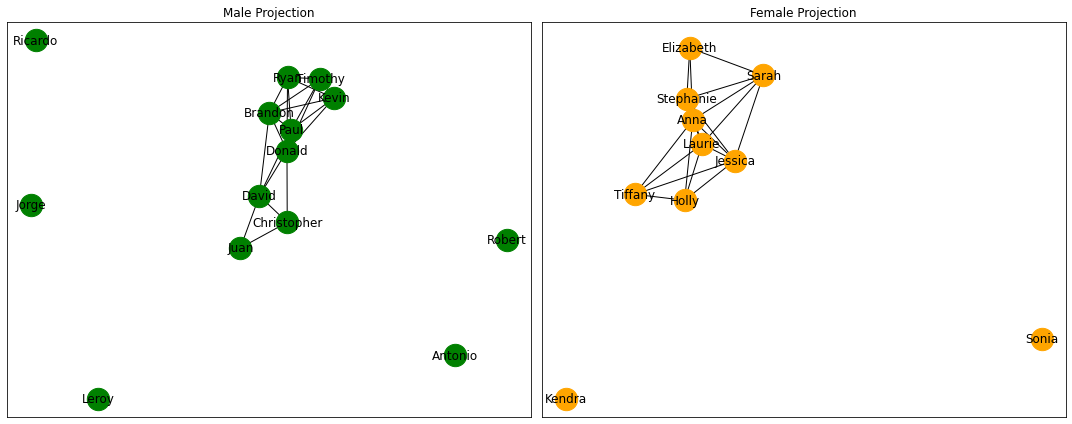

In [23]:
male_projection = nx.bipartite.projected_graph(G, top_nodes)
female_projection = nx.bipartite.projected_graph(G, bottom_nodes)

# Create two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

pos = nx.spring_layout(G, seed=50)

# Plot histogram for male degrees
nx.draw_networkx_nodes(male_projection,
                       pos,
                       node_color='green',
                       node_size=500,
                       ax=ax[0])
nx.draw_networkx_edges(male_projection, pos, width=1, ax=ax[0])
nx.draw_networkx_labels(male_projection, pos,
                        font_size=12, font_family='sans-serif',
                        ax=ax[0])
ax[0].set_title('Male Projection')

# Plot histogram for female degrees
nx.draw_networkx_nodes(female_projection,
                       pos,
                       node_color='orange',
                       node_size=500,
                       ax=ax[1])
nx.draw_networkx_edges(female_projection, pos, width=1, ax=ax[1])
nx.draw_networkx_labels(female_projection, pos,
                        font_size=12, font_family='sans-serif',
                        ax=ax[1])
ax[1].set_title('Female Projection')

# Adjust space between plots
plt.tight_layout()
plt.savefig('undir_proj.png', dpi=100)

# Show the plot
plt.show()



# Speed Dating as Directed Graphs

In [24]:
# Initialize a Graph
DiG = nx.DiGraph()

# Create nodes
for idx, row in filtered.iterrows():
    DiG.add_node(row['new_id'], gender=row['gender'])

# Filter rows where dec_o equals 1
decision_df = filtered[filtered['dec_o'] == 1]
    
# Create directed edges with attr_o as weight
for idx, row in decision_df.iterrows():
    DiG.add_edge(row['new_partner_id'], row['new_id'], weight=row['attr_o'])

In [25]:
def plot_network(G):
    # Determine the nodes for each partition
    top_nodes = [n for n, d in G.nodes(data=True) if d['gender']==1]  # assuming 1 is male
    bottom_nodes = [n for n, d in G.nodes(data=True) if d['gender']==0]  # assuming 0 is female

    # Create the spring layout
    pos = pos = nx.kamada_kawai_layout(G)

    # Get edge weights for alpha value
    weights = nx.get_edge_attributes(G, 'weight')
    max_weight = max(weights.values())
    weights = [weights[edge]/max_weight for edge in G.edges()]  # normalize weights to [0,1] range

    # Draw the graph
    plt.figure(figsize=(10,10))

    # Nodes
    nx.draw_networkx_nodes(G, pos, nodelist=top_nodes, node_color='green', node_size=500)
    nx.draw_networkx_nodes(G, pos, nodelist=bottom_nodes, node_color='orange', node_size=500)

    # Edges (directed)
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15, edge_color='black', 
                           width=1, alpha=weights, connectionstyle='arc3,rad=0.1')

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('dir.png', dpi=100)
    plt.show()


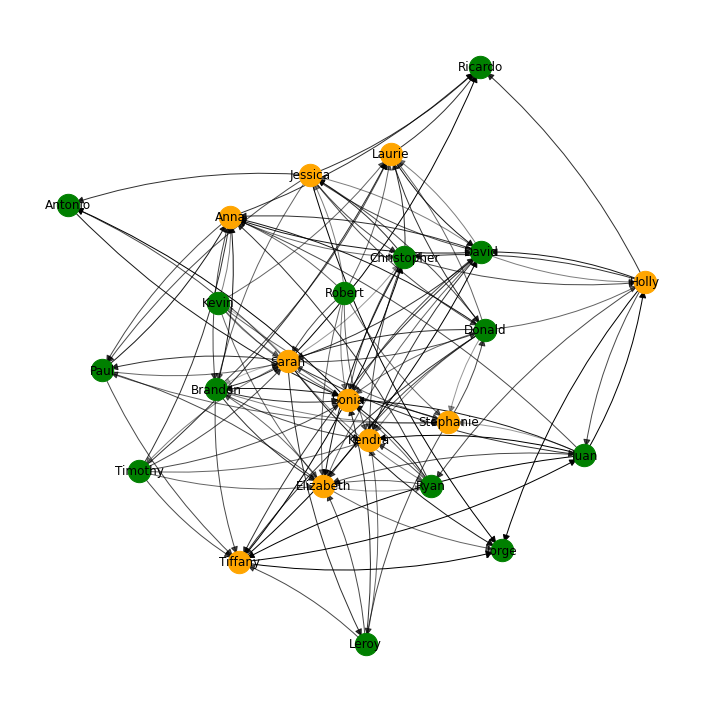

In [26]:
plot_network(DiG)

In [27]:
# Initialize lists to store data
nodes_list = []
in_degree_list = []
out_degree_list = []
weighted_in_degree_list = []
weighted_out_degree_list = []
gender_list = []

# Loop over genders
for gender, color in zip([0, 1], ['female', 'male']):
    # Select nodes of this gender
    selected_nodes = [n for n, d in DiG.nodes(data=True) if d['gender']==gender]
    
    # Compute degrees
    in_degrees = [DiG.in_degree(n) for n in selected_nodes]
    out_degrees = [DiG.out_degree(n) for n in selected_nodes]
    weighted_in_degrees = [DiG.in_degree(n, weight='weight') / DiG.in_degree(n) if DiG.in_degree(n) > 0 else 0 for n in selected_nodes]
    weighted_out_degrees = [DiG.out_degree(n, weight='weight') / DiG.out_degree(n) if DiG.out_degree(n) > 0 else 0 for n in selected_nodes]
    
    avg_in_deg = sum(in_degrees) / len(in_degrees) if in_degrees else 0
    avg_out_deg = sum(out_degrees) / len(out_degrees) if out_degrees else 0
    avg_weighted_in_deg = sum(weighted_in_degrees) / len(weighted_in_degrees) if weighted_in_degrees else 0
    avg_weighted_out_deg = sum(weighted_out_degrees) / len(weighted_out_degrees) if weighted_out_degrees else 0

    # Store results
    nodes_list.append(len(selected_nodes))
    in_degree_list.append(avg_in_deg)
    out_degree_list.append(avg_out_deg)
    weighted_in_degree_list.append(avg_weighted_in_deg)
    weighted_out_degree_list.append(avg_weighted_out_deg)
    gender_list.append(color)

# Create DataFrame
df = pd.DataFrame({
    'gender': gender_list,
    'nodes': nodes_list,
    'avg_in_degree': in_degree_list,
    'avg_out_degree': out_degree_list,
    'avg_weighted_in_degree': weighted_in_degree_list,
    'avg_weighted_out_degree': weighted_out_degree_list
})

df

,gender,nodes,avg_in_degree,avg_out_degree,avg_weighted_in_degree,avg_weighted_out_degree
0,female,10,7.400000,4.700000,6.813586,7.135513
1,male,14,3.357143,5.285714,6.519048,6.073299


In [28]:
# Select nodes for males and females
male_nodes = [n for n, d in DiG.nodes(data=True) if d['gender']==1]
female_nodes = [n for n, d in DiG.nodes(data=True) if d['gender']==0]

# Compute degrees and sort for males
male_in_degrees = sorted([(n, DiG.in_degree(n)) for n in male_nodes], key=lambda x: -x[1])
male_out_degrees = sorted([(n, DiG.out_degree(n)) for n in male_nodes], key=lambda x: -x[1])
male_weighted_in_degrees = sorted([(n, DiG.in_degree(n, weight='weight') / DiG.in_degree(n) if DiG.in_degree(n) > 0 else 0) for n in male_nodes], key=lambda x: -x[1])
male_weighted_out_degrees = sorted([(n, DiG.out_degree(n, weight='weight') / DiG.out_degree(n) if DiG.out_degree(n) > 0 else 0) for n in male_nodes], key=lambda x: -x[1])

# Compute degrees and sort for females
female_in_degrees = sorted([(n, DiG.in_degree(n)) for n in female_nodes], key=lambda x: -x[1])
female_out_degrees = sorted([(n, DiG.out_degree(n)) for n in female_nodes], key=lambda x: -x[1])
female_weighted_in_degrees = sorted([(n, DiG.in_degree(n, weight='weight') / DiG.in_degree(n) if DiG.in_degree(n) > 0 else 0) for n in female_nodes], key=lambda x: -x[1])
female_weighted_out_degrees = sorted([(n, DiG.out_degree(n, weight='weight') / DiG.out_degree(n) if DiG.out_degree(n) > 0 else 0) for n in female_nodes], key=lambda x: -x[1])

# Create DataFrame
df = pd.DataFrame({
    'male_in_degree': pd.Series(male_in_degrees),
    'female_in_degree': pd.Series(female_in_degrees),
    'male_out_degree': pd.Series(male_out_degrees),
    'female_out_degree': pd.Series(female_out_degrees),
    'male_avg_weighted_in_degree': pd.Series(male_weighted_in_degrees),
    'female_avg_weighted_in_degree': pd.Series(female_weighted_in_degrees),
    'male_avg_weighted_out_degree': pd.Series(male_weighted_out_degrees),
    'female_avg_weighted_out_degree': pd.Series(female_weighted_out_degrees)
})

df

,male_in_degree,female_in_degree,male_out_degree,female_out_degree,male_avg_weighted_in_degree,female_avg_weighted_in_degree,male_avg_weighted_out_degree,female_avg_weighted_out_degree
0,"(David, 6)","(Sonia, 11)","(Donald, 10)","(Sarah, 13)","(Jorge, 9.0)","(Tiffany, 7.714285714285714)","(Antonio, 9.0)","(Sonia, 10.0)"
1,"(Jorge, 5)","(Elizabeth, 10)","(Brandon, 8)","(Jessica, 8)","(David, 8.666666666666666)","(Anna, 7.666666666666667)","(Juan, 8.142857142857142)","(Tiffany, 10.0)"
2,"(Christopher, 5)","(Kendra, 9)","(David, 8)","(Holly, 6)","(Ricardo, 8.4)","(Sonia, 7.363636363636363)","(Christopher, 7.666666666666667)","(Laurie, 8.333333333333334)"
3,"(Ricardo, 5)","(Anna, 9)","(Robert, 8)","(Anna, 5)","(Antonio, 8.333333333333334)","(Holly, 7.0)","(Brandon, 7.375)","(Holly, 8.166666666666666)"
4,"(Brandon, 5)","(Laurie, 7)","(Juan, 7)","(Tiffany, 4)","(Juan, 8.333333333333334)","(Kendra, 6.888888888888889)","(Ryan, 7.2)","(Stephanie, 7.666666666666667)"
5,"(Donald, 4)","(Sarah, 7)","(Timothy, 7)","(Elizabeth, 4)","(Leroy, 7.5)","(Elizabeth, 6.8)","(Leroy, 7.0)","(Jessica, 7.5)"
6,"(Paul, 4)","(Tiffany, 7)","(Christopher, 6)","(Laurie, 3)","(Donald, 7.25)","(Sarah, 6.714285714285714)","(Paul, 7.0)","(Anna, 7.4)"
7,"(Antonio, 3)","(Stephanie, 6)","(Kevin, 6)","(Stephanie, 3)","(Paul, 7.25)","(Laurie, 6.571428571428571)","(Timothy, 7.0)","(Sarah, 6.538461538461538)"
8,"(Juan, 3)","(Holly, 4)","(Ryan, 5)","(Sonia, 1)","(Christopher, 7.0)","(Jessica, 6.25)","(Donald, 6.6)","(Elizabeth, 5.75)"
9,"(Ryan, 3)","(Jessica, 4)","(Leroy, 4)","(Kendra, 0)","(Brandon, 6.2)","(Stephanie, 5.166666666666667)","(David, 6.5)","(Kendra, 0)"


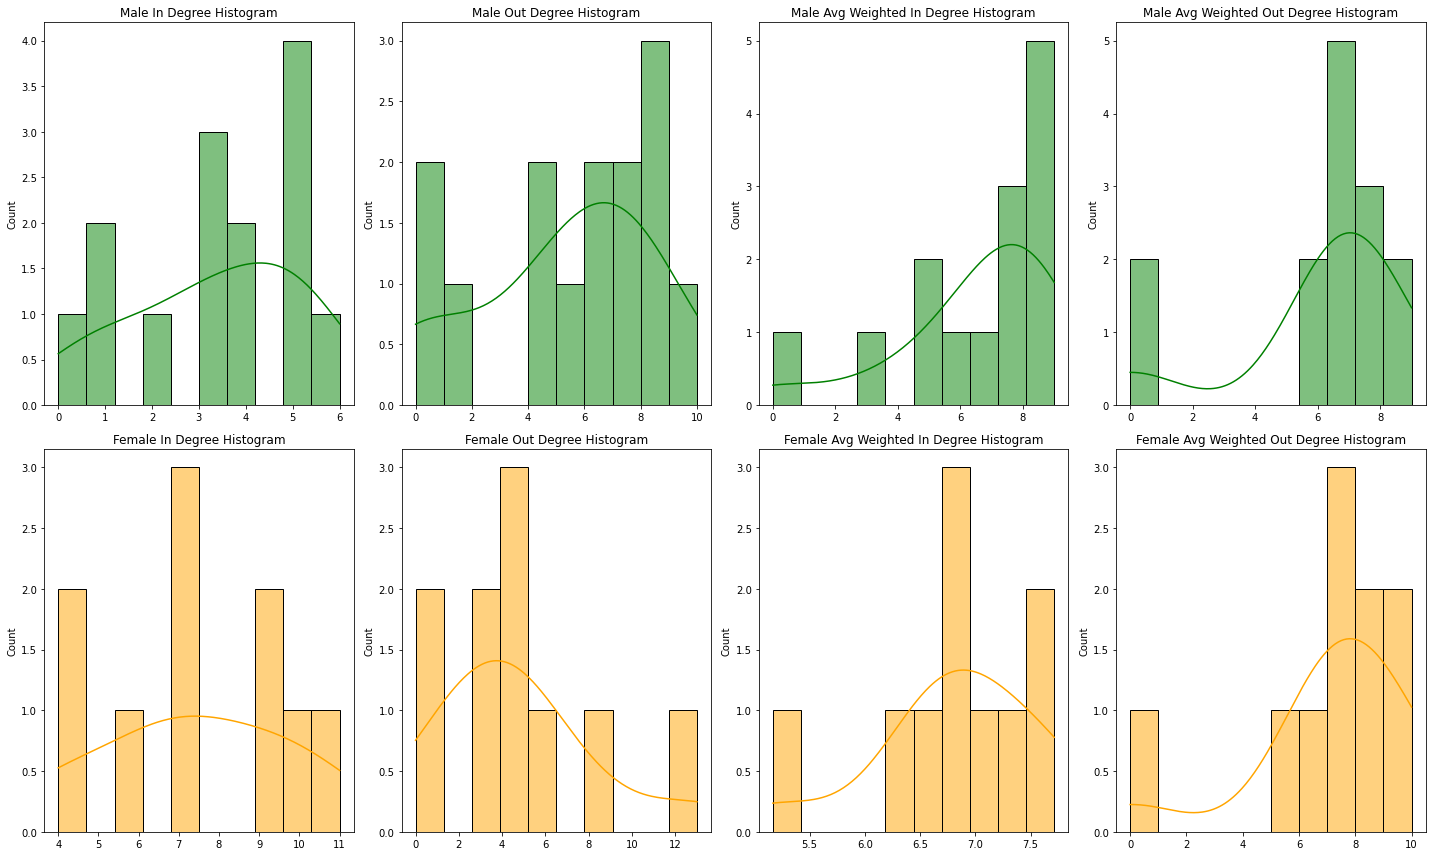

In [29]:
# Create a 2x4 subplot grid
fig, ax = plt.subplots(2, 4, figsize=(20, 12))

# Data extraction
male_in_degrees = [degree for node, degree in male_in_degrees]
female_in_degrees = [degree for node, degree in female_in_degrees]
male_out_degrees = [degree for node, degree in male_out_degrees]
female_out_degrees = [degree for node, degree in female_out_degrees]
male_avg_weighted_in_degrees = [degree for node, degree in male_weighted_in_degrees]
female_avg_weighted_in_degrees = [degree for node, degree in female_weighted_in_degrees]
male_avg_weighted_out_degrees = [degree for node, degree in male_weighted_out_degrees]
female_avg_weighted_out_degrees = [degree for node, degree in female_weighted_out_degrees]

# Histograms
sns.histplot(male_in_degrees, kde=True, color='green', bins=10, ax=ax[0,0])
ax[0,0].set_title('Male In Degree Histogram')
sns.histplot(male_out_degrees, kde=True, color='green', bins=10, ax=ax[0,1])
ax[0,1].set_title('Male Out Degree Histogram')
sns.histplot(male_avg_weighted_in_degrees, kde=True, color='green', bins=10, ax=ax[0,2])
ax[0,2].set_title('Male Avg Weighted In Degree Histogram')
sns.histplot(male_avg_weighted_out_degrees, kde=True, color='green', bins=10, ax=ax[0,3])
ax[0,3].set_title('Male Avg Weighted Out Degree Histogram')

sns.histplot(female_in_degrees, kde=True, color='orange', bins=10, ax=ax[1,0])
ax[1,0].set_title('Female In Degree Histogram')
sns.histplot(female_out_degrees, kde=True, color='orange', bins=10, ax=ax[1,1])
ax[1,1].set_title('Female Out Degree Histogram')
sns.histplot(female_avg_weighted_in_degrees, kde=True, color='orange', bins=10, ax=ax[1,2])
ax[1,2].set_title('Female Avg Weighted In Degree Histogram')
sns.histplot(female_avg_weighted_out_degrees, kde=True, color='orange', bins=10, ax=ax[1,3])
ax[1,3].set_title('Female Avg Weighted Out Degree Histogram')

# Adjust space between plots
plt.tight_layout()
plt.savefig('dir_hists.png', dpi=100)

# Show the plot
plt.show()


In [30]:
# Compute the in-degree and out-degree centralities
in_degree_centralities = sorted(nx.in_degree_centrality(DiG).items(), key=lambda x: -x[1])
out_degree_centralities = sorted(nx.out_degree_centrality(DiG).items(), key=lambda x: -x[1])

df_centrality = pd.DataFrame({
    'InDegree': in_degree_centralities,
    'OutDegree': out_degree_centralities
})

# Display the dataframe
df_centrality

,InDegree,OutDegree
0,"(Sonia, 0.4782608695652174)","(Sarah, 0.5652173913043478)"
1,"(Elizabeth, 0.43478260869565216)","(Donald, 0.43478260869565216)"
2,"(Kendra, 0.3913043478260869)","(Jessica, 0.34782608695652173)"
3,"(Anna, 0.3913043478260869)","(Brandon, 0.34782608695652173)"
4,"(Laurie, 0.30434782608695654)","(David, 0.34782608695652173)"
5,"(Sarah, 0.30434782608695654)","(Robert, 0.34782608695652173)"
6,"(Tiffany, 0.30434782608695654)","(Juan, 0.30434782608695654)"
7,"(Stephanie, 0.2608695652173913)","(Timothy, 0.30434782608695654)"
8,"(David, 0.2608695652173913)","(Holly, 0.2608695652173913)"
9,"(Jorge, 0.21739130434782608)","(Christopher, 0.2608695652173913)"
